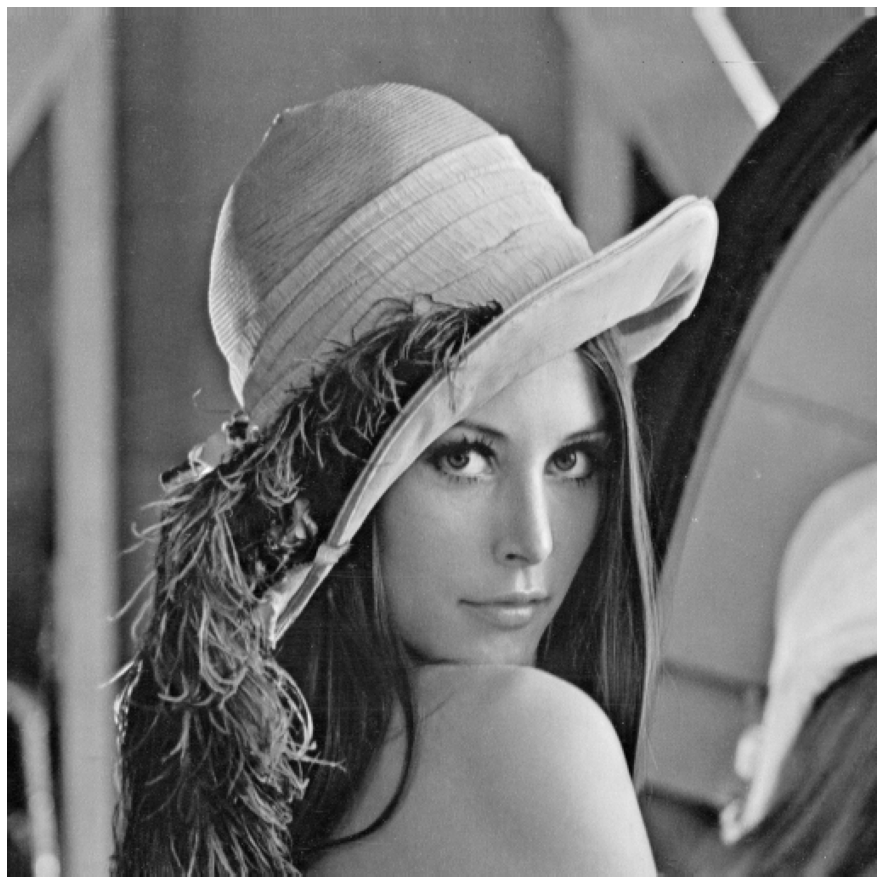

In [119]:
import numpy as np
import pywt
import pywt.data
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
from skimage.restoration import estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
img = mpimg.imread('Lenna.jpg')
img = np.mean(img,-1)#zamiana na obraz czarnobiały
plt.axis('off')
plt.imshow(img, cmap=plt.get_cmap("gray"))
plt.imsave('lenaoriginal'+'.png',img.astype('uint8'),cmap = 'gray')

In [120]:
#nazwa użytej falki
wname = 'db1'
#poziom dekompozyji
n = 9 
#tryb (zalecany 'periodization' dla każdego z obrazów)

#przetworzony obraz zostaje przechowany w formie listy gdzie elementy oznaczają następująco
#0 -> (array) warstwa przybliżająca danego poziomu falki
#1 -> (tuple3 of arrays) warstwa detali dla ostatniego poziomu dekompozycji 
C = pywt.wavedec2(img,wavelet=wname,level=n,mode='periodization',axes=(-2,-1))

# oryginał obrazu uzyskany za pomocą odwrócenia operacji dekompozycji falkowej
imgr = pywt.waverec2(C,wavelet=wname,mode='periodization',axes=(-2,-1))
imgr = np.uint(imgr)

#Normalizacja wyników
C[0] /= np.abs(C[0]).max()
for detail_level in range(n):
    C[detail_level + 1] = [d/np.abs(d).max() for d in C[detail_level + 1]]
#uzyskanie każdej z warstwy dekompozycji obrazu
#warstwa przybliżenia poziom 2
cA2 = C[0]
#warstwa detali (horizontal,vertical,diagonal)
#poziom 1
(cH1,cV1,cD1) = C[-1]
#poziom 2
(cH2,cV2,cD2) = C[-2]

arr, coeff_slices = pywt.coeffs_to_array(C)

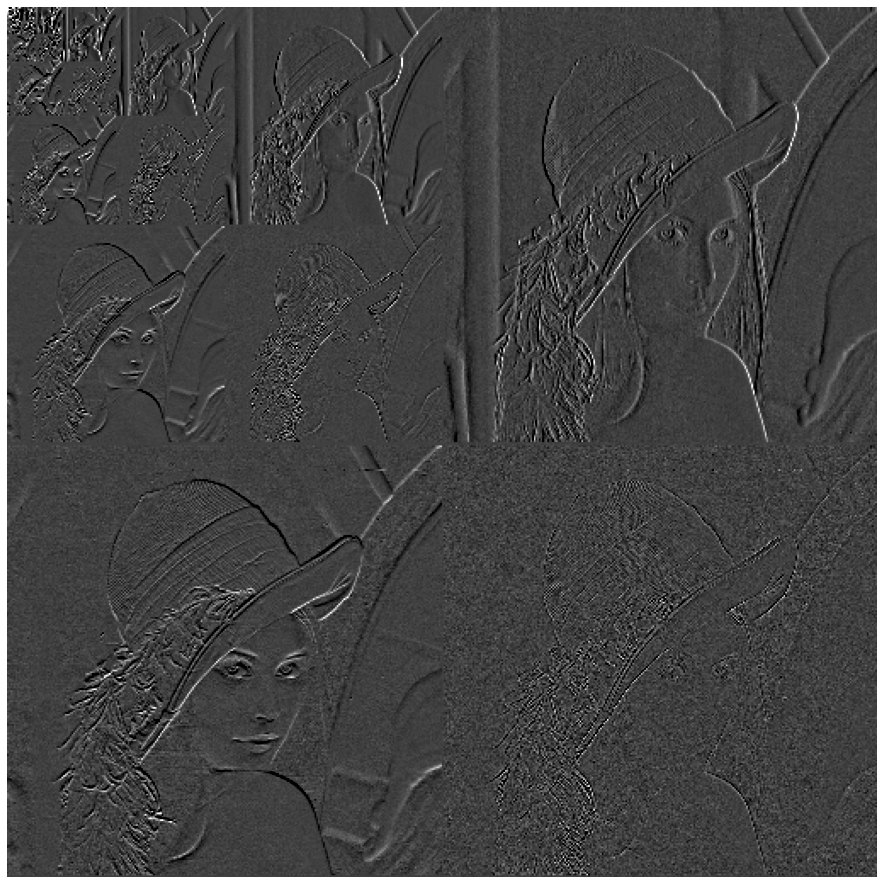

In [121]:
#prezentacja rezulatatów
plt.imshow(arr,cmap='gray',vmin=-0.25,vmax=0.75)
plt.axis('off')
plt.show()

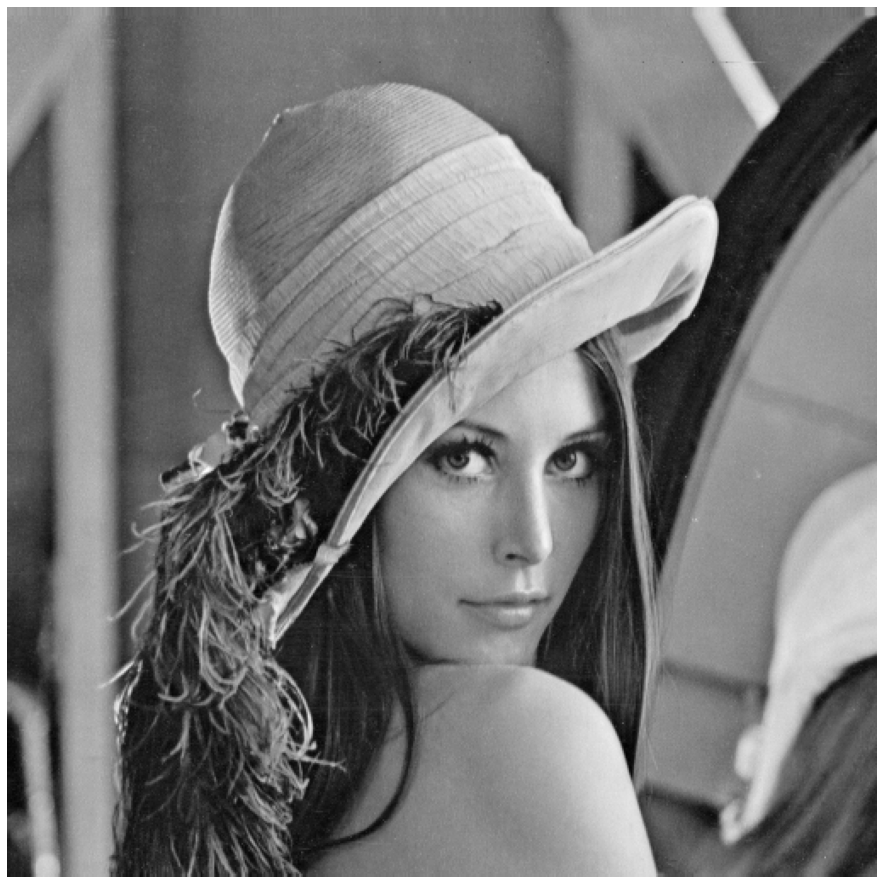

In [122]:
#wyniki odwrócenia operacji falki
plt.axis('off')
plt.imshow(imgr, cmap=plt.get_cmap("gray"))

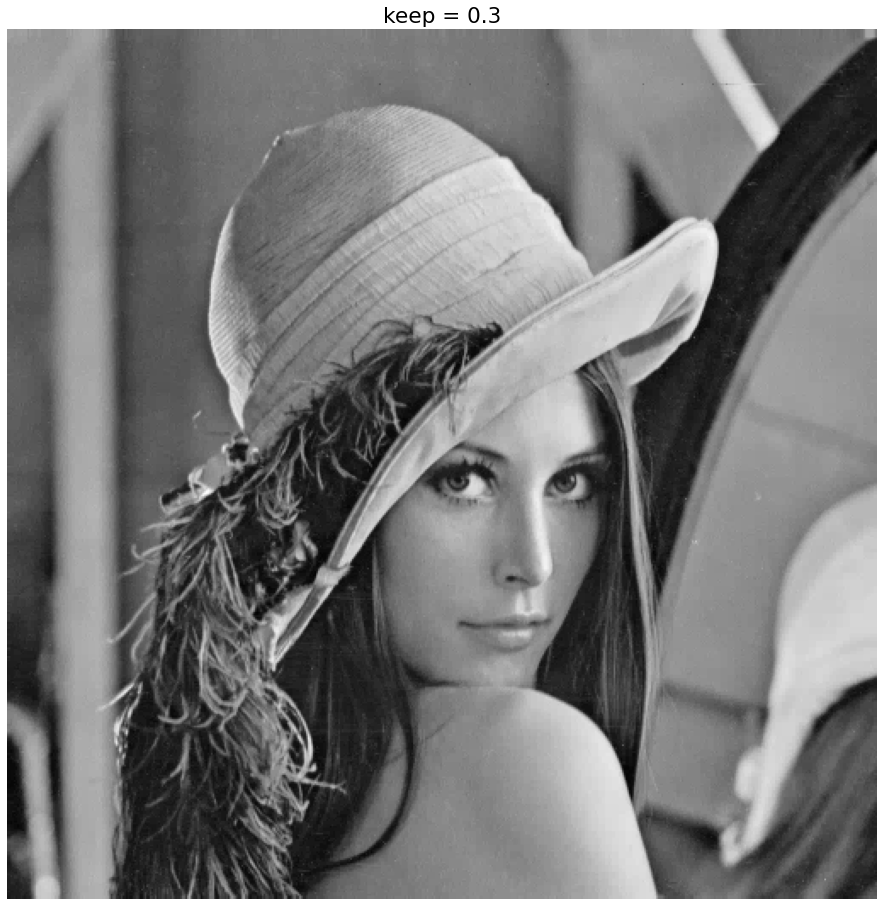

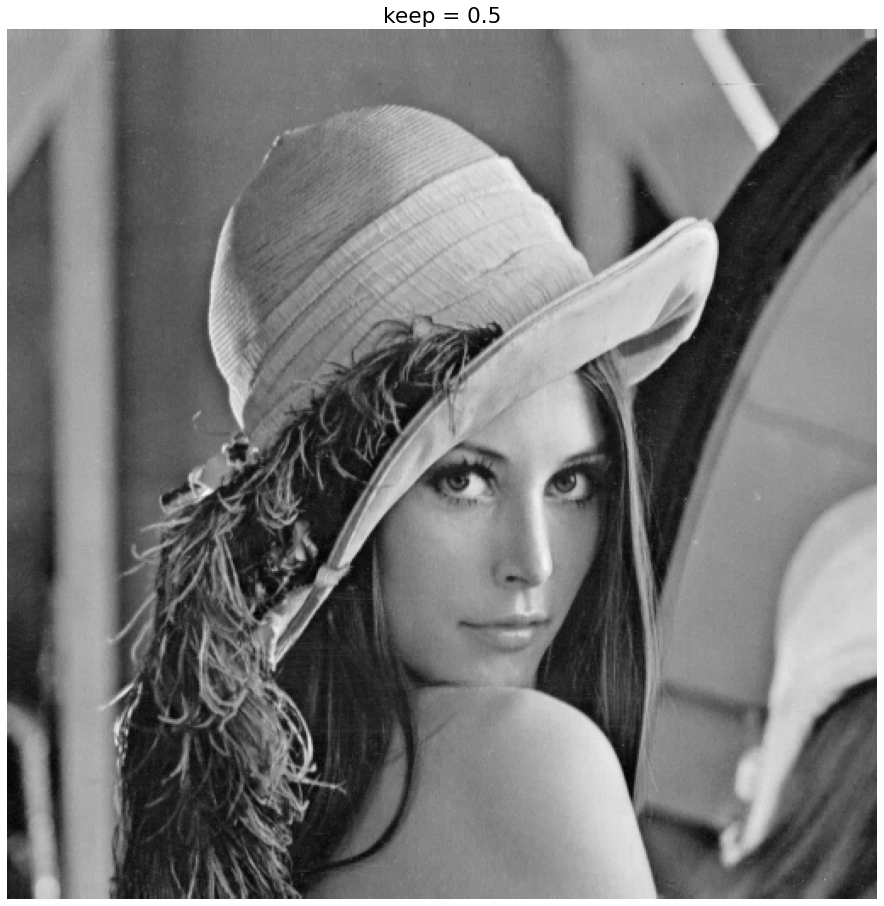

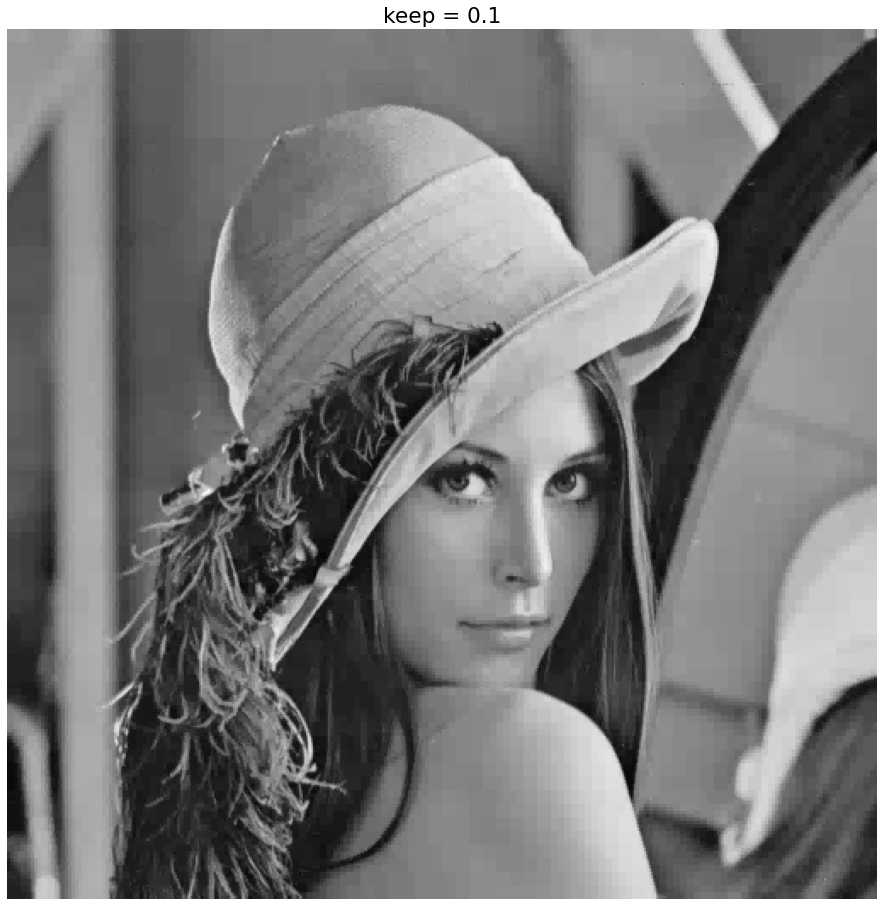

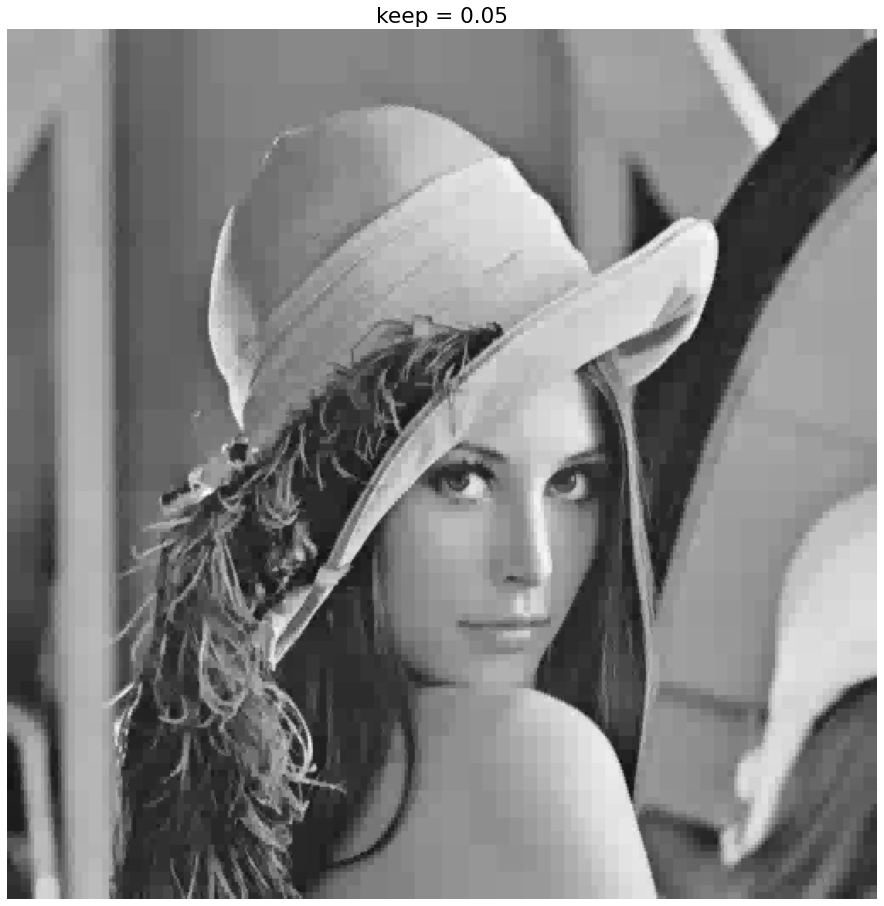

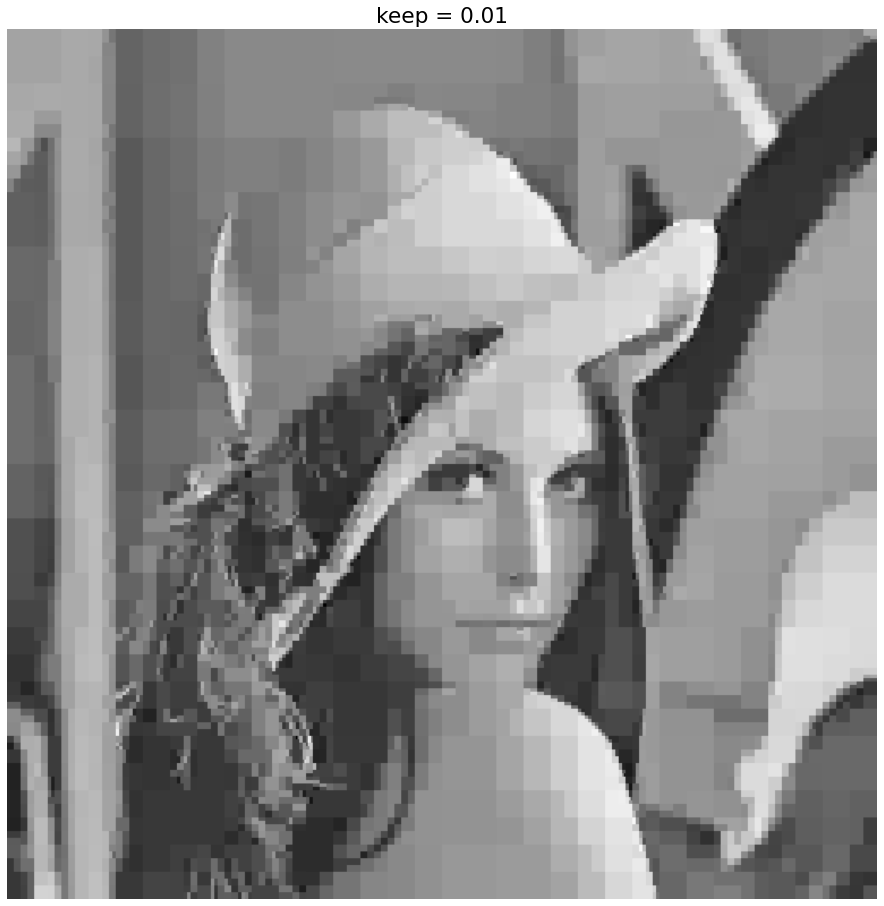

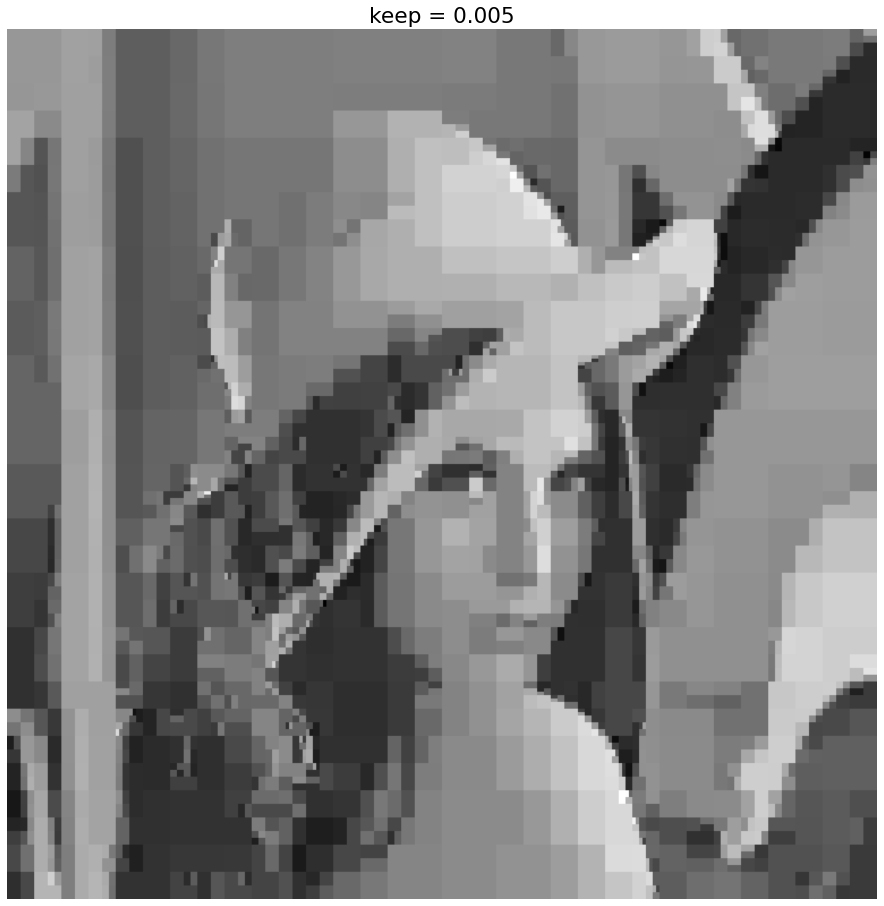

In [123]:
coeffs = pywt.wavedec2(img,wavelet=wname,level=n)

coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

for keep in (0.3,0.5,0.1, 0.05, 0.01, 0.005):
    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind # Threshold small indices
    
    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec2')
    
    # Plot reconstruction
    Arecon = pywt.waverec2(coeffs_filt,wavelet=wname)
    plt.figure()
    plt.imshow(Arecon.astype('uint8'),cmap='gray')
    plt.axis('off')
    plt.title('keep = ' + str(keep))
    plt.imsave('lenacompressed'+str(keep)+'.png',Arecon.astype('uint8'),cmap = 'gray')

(512, 512)


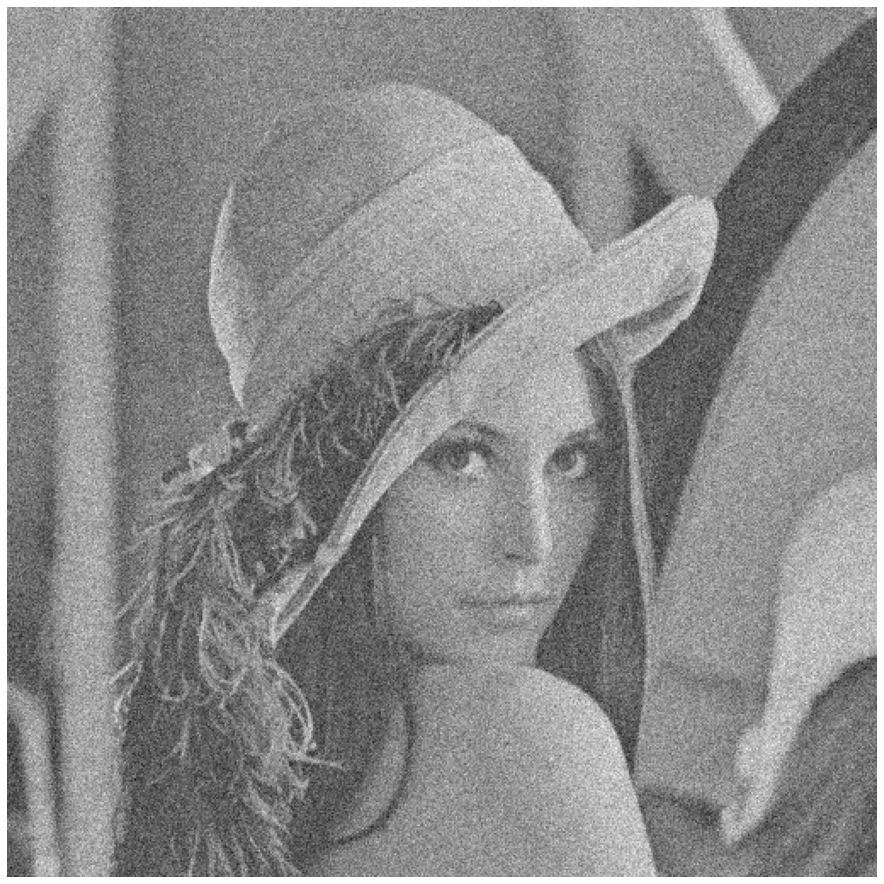

In [124]:
noiseSigma = 27.0
levels = (np.floor(np.log2(img.shape[0]))).astype(int)
prenoise = img.copy()
img += np.random.normal(0, noiseSigma, size=img.shape)
print(img.shape)
plt.axis('off')
plt.imshow(img, cmap=plt.get_cmap("gray"))


In [125]:
"""
WaveletCoeffs = pywt.wavedec2( img, wavelet=wname, level=1)
threshold = noiseSigma*np.sqrt(2*np.log2(img.size))

cA = WaveletCoeffs[0]

tupleDetails = WaveletCoeffs[1]
c0,c1,c2 = tupleDetails
c0 = pywt.threshold(c0,threshold,mode = 'soft')
c1 = pywt.threshold(c1,threshold,mode = 'soft')
c2 = pywt.threshold(c2,threshold,mode = 'soft')
denoised_tupleDetails = (c0,c1,c2)


denoised_coeffs = []
denoised_coeffs.append(cA2)
denoised_coeffs.append(denoised_tupleDetails)

NewImage = pywt.waverec2( denoised_coeffs, wavelet=wname)

plt.imshow(NewImage, cmap=plt.get_cmap("gray"))
"""

'\nWaveletCoeffs = pywt.wavedec2( img, wavelet=wname, level=1)\nthreshold = noiseSigma*np.sqrt(2*np.log2(img.size))\n\ncA = WaveletCoeffs[0]\n\ntupleDetails = WaveletCoeffs[1]\nc0,c1,c2 = tupleDetails\nc0 = pywt.threshold(c0,threshold,mode = \'soft\')\nc1 = pywt.threshold(c1,threshold,mode = \'soft\')\nc2 = pywt.threshold(c2,threshold,mode = \'soft\')\ndenoised_tupleDetails = (c0,c1,c2)\n\n\ndenoised_coeffs = []\ndenoised_coeffs.append(cA2)\ndenoised_coeffs.append(denoised_tupleDetails)\n\nNewImage = pywt.waverec2( denoised_coeffs, wavelet=wname)\n\nplt.imshow(NewImage, cmap=plt.get_cmap("gray"))\n'

In [126]:
#WaveletCoeffs = pywt.wavedec2( img, wavelet=wname, level=5)
#print(len(WaveletCoeffs))

(512, 512)
(512, 512)
(512, 512)
PSNR [Original vs Noisy Image]:  19.469252691521934
PSNR [Original vs Denoised Image]:  25.550631007933013


C:\Users\Adam\AppData\Local\Temp\ipykernel_11336\2504969624.py:30: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_noisy = peak_signal_noise_ratio(prenoise.astype('uint8'),img)
C:\Users\Adam\AppData\Local\Temp\ipykernel_11336\2504969624.py:31: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_wavelet = peak_signal_noise_ratio(prenoise.astype('uint8'),denoisedImage)


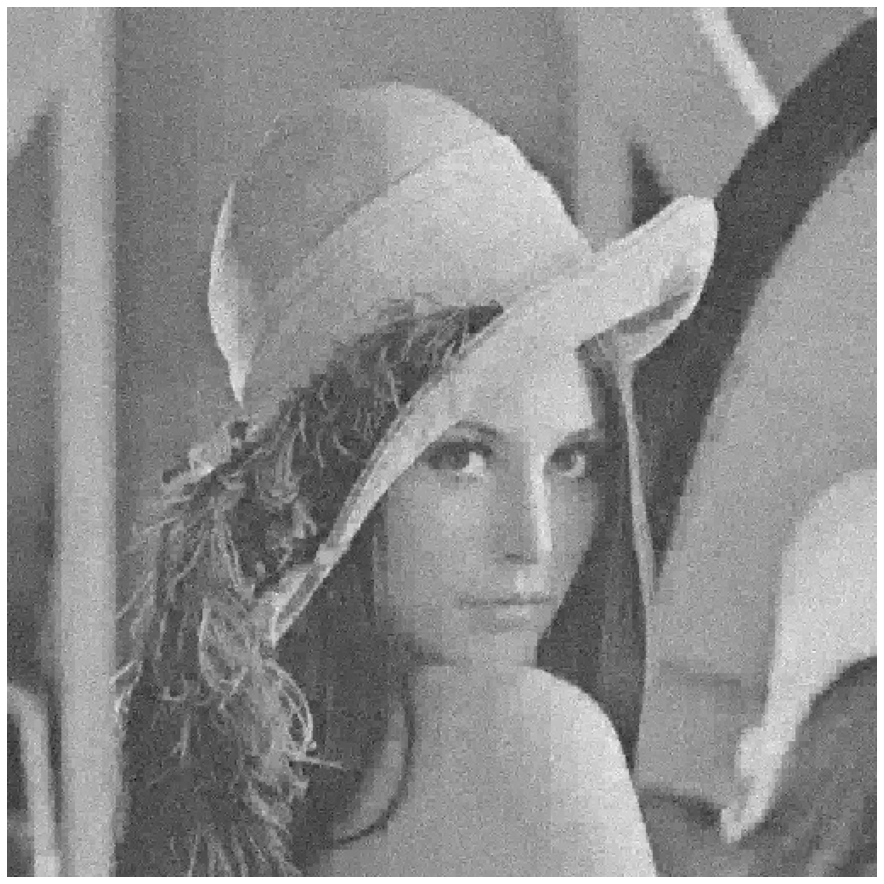

In [132]:
def denoiseImage(image, waveletLvl,waveletName,thresholdMode):
    #threshold = noiseSigma*np.sqrt(2*np.log2(image.size))
    threshold = estimate_sigma(image,average_sigmas = True)
    denoisedCoeffs = []
    waveletCoeffs = pywt.wavedec2( image, wavelet=waveletName, level=waveletLvl)
    cA = waveletCoeffs[0]
    denoisedCoeffs.append(cA)

    detailCoeffs = waveletCoeffs[1:]
    
    for dC in detailCoeffs:
        c0,c1,c2 = dC
        c0 = pywt.threshold(c0,threshold,mode = thresholdMode)
        c1 = pywt.threshold(c1,threshold,mode = thresholdMode)
        c2 = pywt.threshold(c2,threshold,mode = thresholdMode)
        denoised_tupleDetails = (c0,c1,c2)
        denoisedCoeffs.append(denoised_tupleDetails)

    return pywt.waverec2( denoisedCoeffs, wavelet=wname)
    
#threshold = noiseSigma*np.sqrt(2*np.log2(img.size))
denoisedImage = denoiseImage(img,9,'db1','soft')
plt.axis('off')
plt.imshow(denoisedImage, cmap=plt.get_cmap("gray"))

#lenuwa = np.mean(img,-1)#zamiana na obraz czarnobiały
print(prenoise.shape)
print(denoisedImage.shape)
print(img.shape)
psnr_noisy = peak_signal_noise_ratio(prenoise.astype('uint8'),img)
psnr_wavelet = peak_signal_noise_ratio(prenoise.astype('uint8'),denoisedImage)
print('PSNR [Original vs Noisy Image]: ',psnr_noisy)
print('PSNR [Original vs Denoised Image]: ',psnr_wavelet)

